In [1]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

OSError: 'C:\\GitHub\\steinmetzlab\\ALpres.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [1]:
import slidingRP

ModuleNotFoundError: No module named 'slidingRP'

### importing

In [3]:
dataOp622_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))

In [4]:
dataOp709_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))

In [4]:
dataOp712_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-12\1'))

In [4]:
dataOp718_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-18\1'))

In [4]:
dataOp809_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-09\1'))

In [3]:
dataOp818_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-18\1'))

In [5]:
dataOp823_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-23\1'))

In [4]:
dataOp425_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [4]:
dataOp621_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-21\1'))

In [5]:
dataOp729_AB32=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-07-29\1'))

In [5]:
dataOp820_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-20\1'))

### figure 1: intro

- the technique works via viral injection of opsin + gcamp.
- we can track brain activity against stimulus using WF and it corresponds with ephys results. 
- we can make pretty images of the brain that correspond to the pixel values we use in analysis.

In [4]:
def brainImg(ax,data,frame,galvoX=0,galvoY=0,power=2,n_samples=650,start=-.3,end=1,X=150,Y=350,colorbarlabel='Brin Activity dF/F',title='',loccolor='left'):
    '''
    image of the brain
    can change where you stim (galvoX, galvoY),
        power you stimulate with, frame you take as peak,
        and samples in trial
        frame which you take your img from, just a single one
    '''
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY)
    galvoXTrs=np.argwhere(data.galvoX==galvoX)
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(loc,pows)

    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(data.tToWFManual(trs),axis=0)
    mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
    mov = mov.reshape(560,560,-1)
    meanimg = data.meanImage.reshape(560,560,-1)
    mov_mean_dff = mov/meanimg
    
    vmin, vmax = np.percentile(mov_mean_dff[:, :, frame], [2, 98])
    norm = Normalize(vmin=-max(abs(vmin), vmax), vmax=max(abs(vmin), vmax))
    plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', norm=norm)
    plt.title(f'{title}')
    plt.colorbar(location=loccolor,label=colorbarlabel)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [5]:
def microscope(ax):
    '''
    shows the light path, path of commands
    '''
    plt.title('microscope')
    plt.xticks([])
    plt.yticks([])
def geneExpression(ax):
    '''
    shows histology, expression of opsin + calcium
    '''
    plt.title('gene expression')
    plt.xticks([])
    plt.yticks([])


In [6]:
def wfTrace(ax,data,powers,galvoX,galvoY,y,x,width=15,n_samples=650,\
            start=-.3,end=1,xlim=[-300,600],\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=2,\
            ylabel=True,fontsizelegend='xx-small',seclabel='ms'):
    '''
    traces of activity in response to different powers for one location in one dataset
        data = what dataset
        powrs = list of powers to plot activity for
        galvoX = X location
        galvoY = Y location
        y = y pixel to center ROI around
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    if len(powers)<3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.Blues(np.linspace(.3,1,lenpows))
    pxPowers = []
    timestamps = np.linspace(start, end, n_samples)*1000
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity

        mov_mean_dff = videoROI/avg
        trace=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(trace)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxPowers,axis=0),\
                power+scipy.stats.sem(pxPowers,axis=0), color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.xlabel(f'Time {seclabel}',fontsize=10)
    if ylabel:
        plt.ylabel('Brain Activity df/f',fontsize=10)
    plt.title(f'{title}',fontsize=13)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)

In [7]:
def wfTraceAvg(ax,dataList,powers,galvoXList,galvoYList,y,x,width=15,\
               n_samples=650,xlim=[-300,600],start=-.3,end=1,\
            ylim=[-0.1,0.04],lenpows=11,anchor=(1,1),title='',cols=2,\
            ylabel=True,fontsizelegend='xx-small',seclabel='ms'):
    '''
    traces of activity in response to different powers for one location in multiple datasets (optionally)
        data = what datasets
        powers = list of powers to plot activity for
        galvoXList = X locations for each dataset - must match with order of dataset list
        galvoY = Y location
        y = y pixel to center ROI around - generic for all datasets
        x = x pixel to center ROI around
        width = how wide from x-y coord to take ROI
        n_samples = how many samples in the time signature
        lenpows = how many powers you have, changes how many colors there are
        anchor = where to anchor the legend
        cols = how many columns for the legend
        ylabel = says whether to create a y-axis label or not
        seclabel = whether the x-axis is in s or ms
        fontsizelegend = the fontsize of the legend text
        title = title
    '''
    if len(powers)<3:
        colors=['deepskyblue','dodgerblue','mediumblue']
    else:
        colors=plt.cm.Blues(np.linspace(.3,1,lenpows))
    
    pxData=[]
    for iD,data in enumerate(dataList):
        pxPowers = []
        timestamps = np.linspace(start, end, n_samples)*1000
        galvoXTr=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTr=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTr,galvoYTr)

        for power in powers:
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))

            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity

            mov_mean_dff = videoROI/avg
            trace=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(trace)
        pxData.append(pxPowers)
        
    pxDataMean = np.mean(pxData,axis=0) 

    powerscorr = [round(i/2.777777778,2) for i in powers]
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i], linewidth=2)[0] for i, y in enumerate(pxDataMean)]

    for iP, power in enumerate(pxDataMean):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxDataMean,axis=0),\
                power+scipy.stats.sem(pxDataMean,axis=0), color=colors[iP],label='_nolegend_',alpha=.3,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize=fontsizelegend,\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.xlabel(f'Time {seclabel}',fontsize=10)
    if ylabel:
        plt.ylabel('Brain Activity df/f',fontsize=10)
    plt.title(f'{title}',fontsize=13)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    plt.xlim(xlim)

In [8]:
def ephys(ax):
    '''
    trace of ephys to contrast with the single pixel activity plot
    '''
    plt.title('ephys activity')
    plt.xticks([])
    plt.yticks([])


#### panels

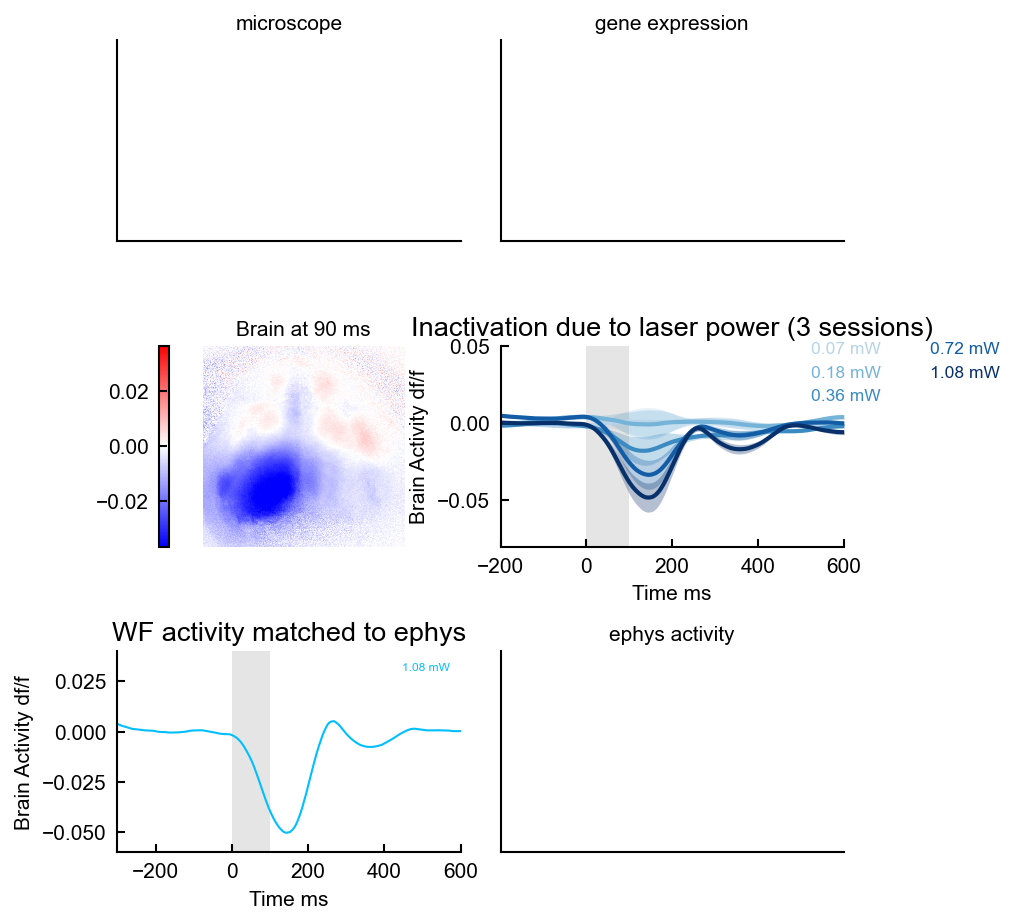

In [20]:
# figure plotting
data=dataOp622_AL33
dataList=[dataOp622_AL33,dataOp809_AL33,dataOp823_AL33]
galvoX=0
galvoY=3
x=170
y=410
xlim=[-200,600]
f = plt.figure(figsize=(7,12))
gs=mpl.gridspec.GridSpec(6,2)

ax = plt.subplot(gs[0])
microscope(ax)

ax = plt.subplot(gs[1])
geneExpression(ax)

ax = plt.subplot(gs[2])
brainImg(ax,data=data,galvoX=galvoX,galvoY=galvoY,power=3,n_samples=650,\
         frame=200,colorbarlabel='',title='Brain at 90 ms')

ax = plt.subplot(gs[3])
wfTraceAvg(ax,dataList=dataList,powers=[0.2,0.5,1,2,3],lenpows=5,\
            galvoXList=[0,0,0,0,0,0,0],galvoYList=[3,3,3],x=x,y=y,xlim=xlim,ylim=[-0.08,0.05],\
            title='Inactivation due to laser power (3 sessions)',anchor=(1.5,1.1),fontsizelegend='small')

ax = plt.subplot(gs[4])
wfTrace(ax,data=data,powers=[3],\
        galvoX=galvoX,galvoY=galvoY,x=x,y=y,ylim=[-0.06,0.04],\
        title='WF activity matched to ephys')

ax = plt.subplot(gs[5])
ephys(ax)

f.tight_layout()

### figure 2: visresp

- In control mice (no opsin) red laser at certain powers and locations evokes response in visual cortex. 
- The magnitude of the visual response is reduced by adapting the retina with flicker. 
- There exists a range of laser powers that inactive neurons while not evoking a detectable visual response. 
- Light intensities used for fluorescence imaging do not drive opsin. 


In [5]:
dataVis822_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-08-22\1'))

In [21]:
dataVis823_ZYE=wfOpto(Path(r'Y:\Subjects\ZYE_0088\2024-08-23\1'))

In [12]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    # powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    timeX = pixelInterp(time)

    return(timeX)

In [13]:
def visRespCompare(ax,data,ylim,exptrs=np.array([0,600,1200]),power=2.5,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   n_samples=300,labels=['No Flicker','Flicker']):
    '''
    trace of response in VC compared with and without flicker 
    '''
    pxPowers = []
    colors=['forestgreen','orange']
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #this depends on mouse (and maybe day) !!!!!
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    for i,iP in enumerate(pxPowers):
        plt.plot(timestamps, iP, color=colors[i],label=labels[i],lw=2)
        plt.fill_between(timestamps, \
                iP-scipy.stats.sem(pxPowers,axis=0),\
                iP+scipy.stats.sem(pxPowers,axis=0), color=colors[i], label='_nolegend_',alpha=.3,linewidth=0)
        
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('Time (ms)',fontsize=10)
    plt.title(f'{title} {round(power/2.777778, 2)} mW', fontsize=13)
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.legend()
    plt.ylim(ylim)

In [14]:
def visRespQuantCompare(ax,data,ylim,exptrs=np.array([0,600,1200]),time=190,galvoX=0,galvoY=0,x=120,y=380,width=15,n_samples=300,labels=['No Flicker','Flicker']):
    '''
    peak of visual activity in VC compared with flicker and no flicker
    '''
    colors=['forestgreen','orange']
    powers = np.unique(data.laserPowers).ravel()
    lenpws = len(powers)
    quantCompare = np.zeros((2,lenpws),dtype=float)
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    labels=['No Flicker', 'Flicker']

    for i in range(2):
        pxPowers=[]
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)

        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        peak = pixelInterp(time)
        quantCompare[i,:] = peak

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for i,peaks in enumerate(quantCompare):
        yerr = scipy.stats.sem(peaks)
        plt.plot(powerscorr,peaks,'-o',c=colors[i],lw=2,label=labels[i])
        plt.errorbar(powerscorr,peaks,yerr=yerr,c=colors[i],label='_nolabel_')
        plt.scatter(powerscorr,peaks,c=colors[i],label='_nolabel_')
    plt.legend()
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'Activation at Peak ({time} ms)',fontsize=13)
    plt.ylim(ylim)

In [15]:
def respQuant(ax,data,ylim,galvoX=0,galvoY=0,x=100,y=390,n_samples=300,time=90,width=15,tr1=0,tr2=600):
    '''
    quantifying how much response there is for how much power for one dataset
        data - dataset
        galvoX - X coordinate for laser
        galvoY - Y coordinate for laser
        x = X location of center of ROI
        y = Y location of center of ROI
        n_samples = how many samples to split signature into
        time = where to take the peak value from
        width = width of ROI from x and y in either direction
        tr1 = first trial number to take trials from
        tr2 = last trial to take trials from
    '''
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
    timeX = pixelInterp(time)
    yerr = scipy.stats.sem(timeX)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    plt.plot(powerscorr,timeX,'-o',c='k',lw=2)
    plt.errorbar(powerscorr,timeX,yerr=yerr,c='k')
    plt.scatter(powerscorr,timeX)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'Activation at Peak ({time} ms)',fontsize=13)
    plt.ylim(ylim)

In [16]:
def respQuantAvg(ax,dataList,ylim,galvoXList,galvoYList,powers,x=100,y=390,n_samples=300,time=90,width=15,title=''):
    '''
    quantifying how much response there is for how much power across datasets
    finds the peak values of each dataset, then averages those values 
        data - dataset
        galvoX - X coordinate for laser
        galvoY - Y coordinate for laser
        x = X location of center of ROI
        y = Y location of center of ROI
        n_samples = how many samples to split signature into
        time = where to take the peak value from
        width = width of ROI from x and y in either direction
        tr1 = first trial number to take trials from
        tr2 = last trial to take trials from
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,data in enumerate(dataList):
        pxPowers = []
        galvoXTrs=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)
        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    pxDataMean = np.mean(pxData,axis=0)
    yerr = scipy.stats.sem(pxData,axis=0)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    plt.plot(powerscorr,pxDataMean,'-o',c='k',lw=2)
    plt.errorbar(powerscorr,pxDataMean,yerr=yerr,c='k')
    plt.scatter(powerscorr,pxDataMean)
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'{title}',fontsize=13)
    plt.ylim(ylim)

In [17]:
def respQuantLoc(ax,data,ylim,galvoYList,powers,x=100,y=390,n_samples=300,time=90,width=15,title=''):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,len(galvoYList)))
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxPowers.append(avgOverRoi)
        pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    yerr = scipy.stats.sem(pxData,axis=0)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for iD,data in enumerate(pxData):
        plt.plot(powerscorr,data,'-o',c=colors[iD],lw=2,label=labels[iD])
        plt.errorbar(powerscorr,data,yerr=yerr,c=colors[iD],label='_nolabel_')
        plt.scatter(powerscorr,data,label='_nolabel_')
    plt.legend()
    plt.xlabel("Laser powers (mW)",fontsize=10)
    plt.title(f'{title}',fontsize=13)
    plt.ylim(ylim)

In [21]:
def adaptTrace830(ax):
    '''
    for 8/30 speificially, shows the trace of the activity in VC when stimulating retina with and without adapting the retina
    '''
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    power=3
    
    #no flicker
    pixel_ix = np.ravel_multi_index((428, 410), (dataVis830.py, dataVis830.px))
    pows = np.argwhere(dataVis830.laserPowers[dataVis830.listExps[1]] == power).ravel()
    onTimes = dataVis830.laserOn[dataVis830.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = dataVis830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataVis830.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)

    #flicker
    pows = np.argwhere(dataVis830.laserPowers[dataVis830.listExps[0]] == power).ravel()
    onTimes = dataVis830.laserOn[dataVis830.listExps[0]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    flicker=[]
    for iT, tr in enumerate(trs):
        wf = dataVis830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataVis830.svdSpat[pixel_ix] @ dwf
        flicker.append(mov)
    flicker = np.array(flicker)

    plt.plot(timestamps, np.mean(noFlicker, axis=0), color='forestgreen')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='forestgreen', alpha=0.3, lw=0, label='without white noise')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color='darkorange')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='darkorange', lw=0, label='with white noise', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    # plt.legend()
    plt.xlim([-100,500])
    plt.xlabel('Time from stim onset(s)')
    plt.ylabel('Activity in visual cortex')

In [22]:
def adaptQuant830(ax):
    '''
    for 8/30 specifically, showing how much visresp is adapted per power
    '''
    powers = np.unique(dataVis830.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (dataVis830.py, dataVis830.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(dataVis830.laserPowers[dataVis830.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = dataVis830.laserOn[dataVis830.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(dataVis830.laserPowers[dataVis830.listExps[1]]== power).ravel()
            onTimesNFlicker = dataVis830.laserOn[dataVis830.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = dataVis830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis830.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = dataVis830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis830.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(dataVis830.laserPowers), noflickInt/constant, c='forestgreen', label='without white noise', **dotkwargs)
    
    # plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(dataVis830.laserPowers), flickInt/constant, c='darkorange', label='with white noise', **dotkwargs)
    
    plt.legend()
    plt.xlabel('Optogenetic laser power (mW)')
    plt.ylabel('Activity in visual cortex')
    # plt.title('Magnitude of Visual Response')

In [23]:
def opsinLight(ax):
    plt.title('Opsin light doesnt drive gcamp')

#### panels comparing locations and powers

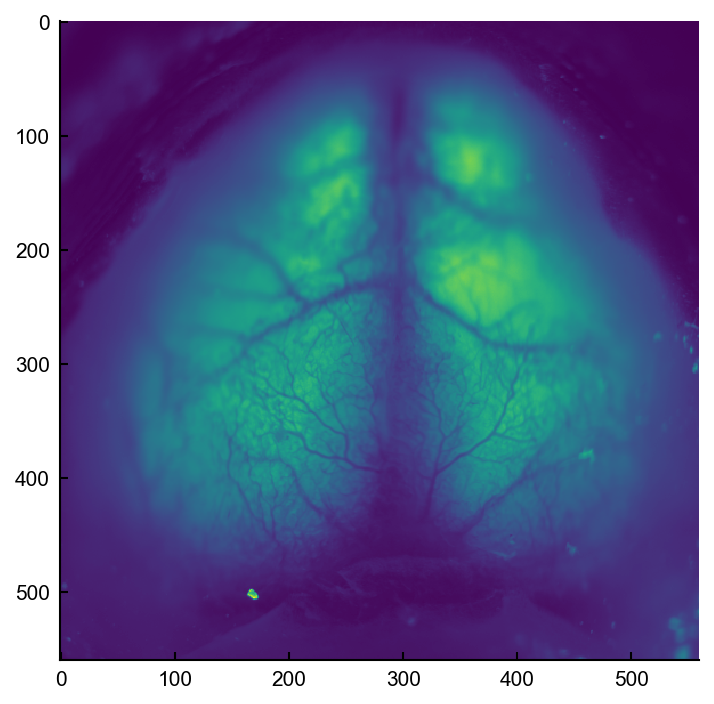

In [24]:
plt.imshow(dataVis822_AL35.meanImage)

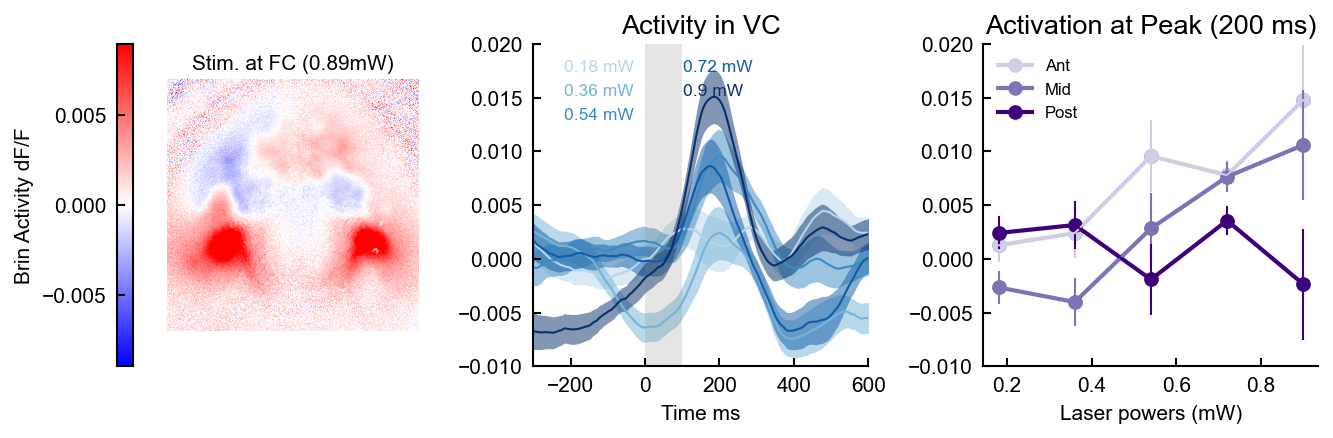

In [31]:
# figure plotting

f = plt.figure(figsize=(9,8))
gs=mpl.gridspec.GridSpec(3,3)

data=dataVis822_AL35
powers=np.unique(data.laserPowers)
lenpws=len(powers)
frame=220
samps=650
quantYlim=[-0.01,0.02]
#frontal cortex
gX=0
gY=0
x=120
y=380
ax = plt.subplot(gs[0])
brainImg(ax,data=data,galvoX=gX,galvoY=gY,frame=frame,n_samples=samps,\
         power=2.5,title='Stim. at FC (0.89mW)')
ax = plt.subplot(gs[1])
wfTrace(ax,data=data,galvoX=gX,galvoY=gY,\
        x=x,y=y,powers=powers,ylim=quantYlim,\
            title='Activity in VC',ylabel=False,lenpows=lenpws,\
                fontsizelegend='small',anchor=(.7,1))
ax = plt.subplot(gs[2])
respQuantLoc(ax,data=data,galvoYList=[0,2.5,4],n_samples=samps,\
          powers=powers,y=y,x=x,time=200,ylim=quantYlim,title='Activation at Peak (200 ms)')

# #somatosensory
# gX=0
# gY=2
# ax = plt.subplot(gs[3])
# brainImg(ax,data=dataVis819,galvoX=gX,galvoY=gY,frame=frame,n_samples=samps,\
#          power=2.5,title='Stim. at SS (0.89 mW)')
# ax = plt.subplot(gs[4])
# wfTrace(ax,data=dataVis819,galvoX=0,galvoY=gY,\
#         x=400,y=450,powers=powers,ylim=quantYlim,\
#             title='',ylabel=False,lenpows=lenpws,\
#                 fontsizelegend='small',anchor=(.7,1))
# ax = plt.subplot(gs[5])
# respQuant(ax,data=dataVis819,galvoX=gX,galvoY=gY,x=120,n_samples=samps,\
#           y=450,time=frame,ylim=quantYlim)

# #VC
# gX=0
# gY=4.5
# ax = plt.subplot(gs[6])
# brainImg(ax,data=dataVis819,galvoX=gX,galvoY=gY,frame=frame,n_samples=samps,\
#         power=2.5,title='Stim. at VisP (0.89 mW)')
# ax = plt.subplot(gs[7])
# wfTrace(ax,data=dataVis819,galvoX=0,galvoY=gY,\
#         x=400,y=450,powers=powers,ylim=quantYlim,\
#             title='',ylabel=False,lenpows=lenpws,\
#                 fontsizelegend='small',anchor=(.7,1))
# ax = plt.subplot(gs[8])
# respQuant(ax,data=dataVis819,galvoX=gX,galvoY=gY,x=120,n_samples=samps,\
#           time=frame,ylim=quantYlim)

f.tight_layout()


In [27]:
len(powers)

5

#### flicker/no flicker comparison

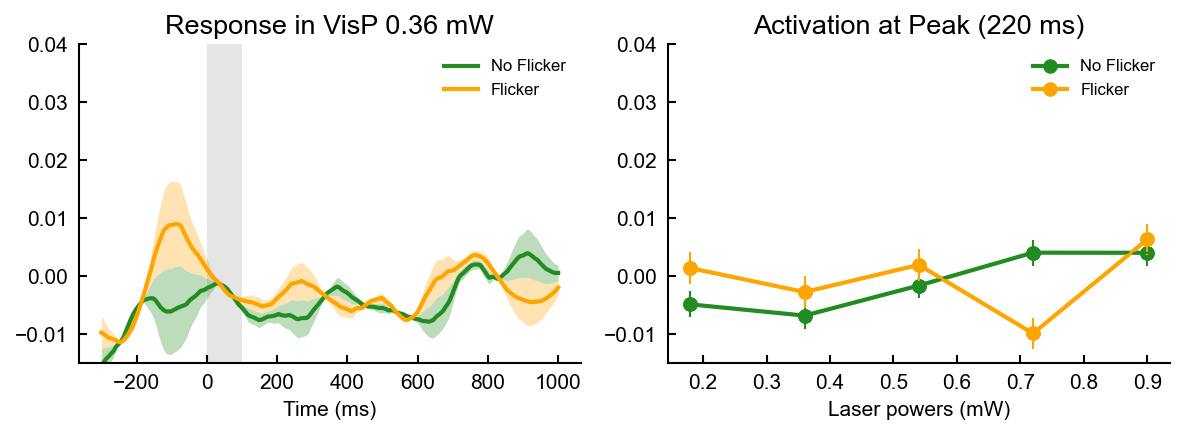

In [31]:
galvoX=0
galvoY=0
time=220
x=120
y=380 
data=dataVis823_ZYE
f=plt.figure(figsize=(8,3))
gs=mpl.gridspec.GridSpec(1,2)

ax=plt.subplot(gs[0])
visRespCompare(ax,data=data,power=1,galvoX=galvoX,galvoY=galvoY,x=x,y=y,n_samples=300,ylim=[-0.015,0.040])

ax=plt.subplot(gs[1])
visRespQuantCompare(ax,data=data,time=time,galvoX=galvoX,galvoY=galvoY,x=x,y=y,n_samples=300,ylim=[-0.015,0.040])


#### opto control comparison

In [22]:
powers5 = np.unique(dataVis823_ZYE.laserPowers)

In [24]:
vis = powerQuantReturn(data=dataVis823_ZYE,powers=powers5,galvoX=0,galvoY=0,x=120,y=380,n_samples=650,time=220,width=15)

In [20]:
opto = powerQuantReturn(data=dataOp818_AL33,powers=np.unique(dataOp818_AL33.laserPowers),galvoX=0,galvoY=0,x=150,y=380,n_samples=650,time=90,width=15)*-1

In [26]:
interp_func = scipy.interpolate.interp1d(powers5, vis, kind='linear', fill_value='extrapolate')
controlinterp = interp_func(np.unique(dataOp818_AL33.laserPowers))

In [27]:
mice=[opto,controlinterp]

Text(0.5, 1.0, 'Opto inhibition and control excitation comparison')

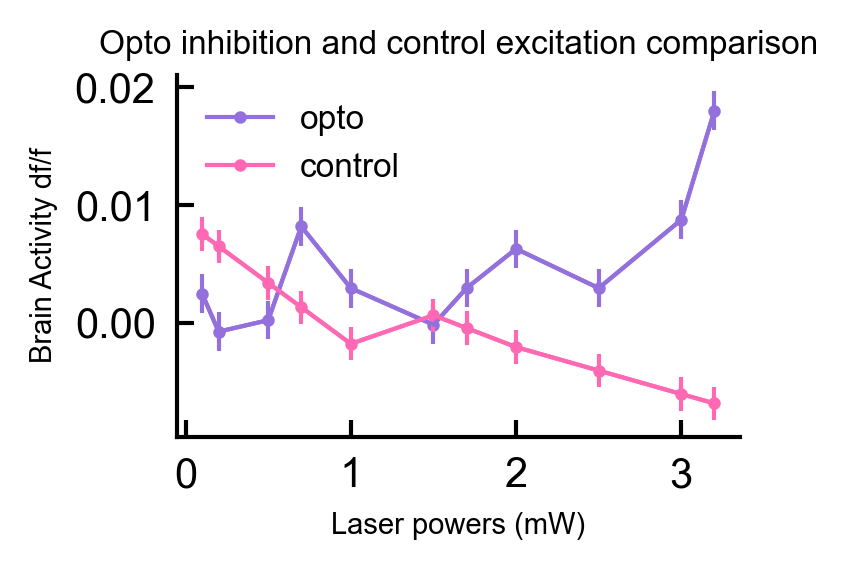

In [30]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers11=np.unique(dataOp818_AL33.laserPowers)
powers = [round(i/2.777777778,2) for i in powers11]
colors=['mediumpurple','hotpink']
labels=['opto','control']

# lines = [plt.plot(powers, y, label=f'{labels[i]}',color=colors[i])[0] for i, y in enumerate(mice)]

for i,mouse in enumerate(mice):
    plt.plot(powers11,mouse,'-o',c=colors[i],lw=1,markersize=2,label=labels[i])

    plt.errorbar(powers11,mouse,yerr=scipy.stats.sem(mouse),c=colors[i])

    plt.scatter(powers11,mouse,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)
plt.legend()
# legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
#                         columnspacing=0.5,handletextpad=0.3)

# # Change the color of the text in the legend to match the line colors
# for text, line in zip(legend.get_texts(), lines):
#     text.set_color(line.get_color())
# # Optionally, remove the lines and markers from the legend
# for legend_line in legend.get_lines():
#     legend_line.set_linewidth(0)
# for legend_marker in legend.get_patches():
#     legend_marker.set_visible(False)

plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel("Brain Activity df/f",fontsize=7)
plt.title("Opto inhibition and control excitation comparison",fontsize=8)

In [82]:
mice[1].size

11

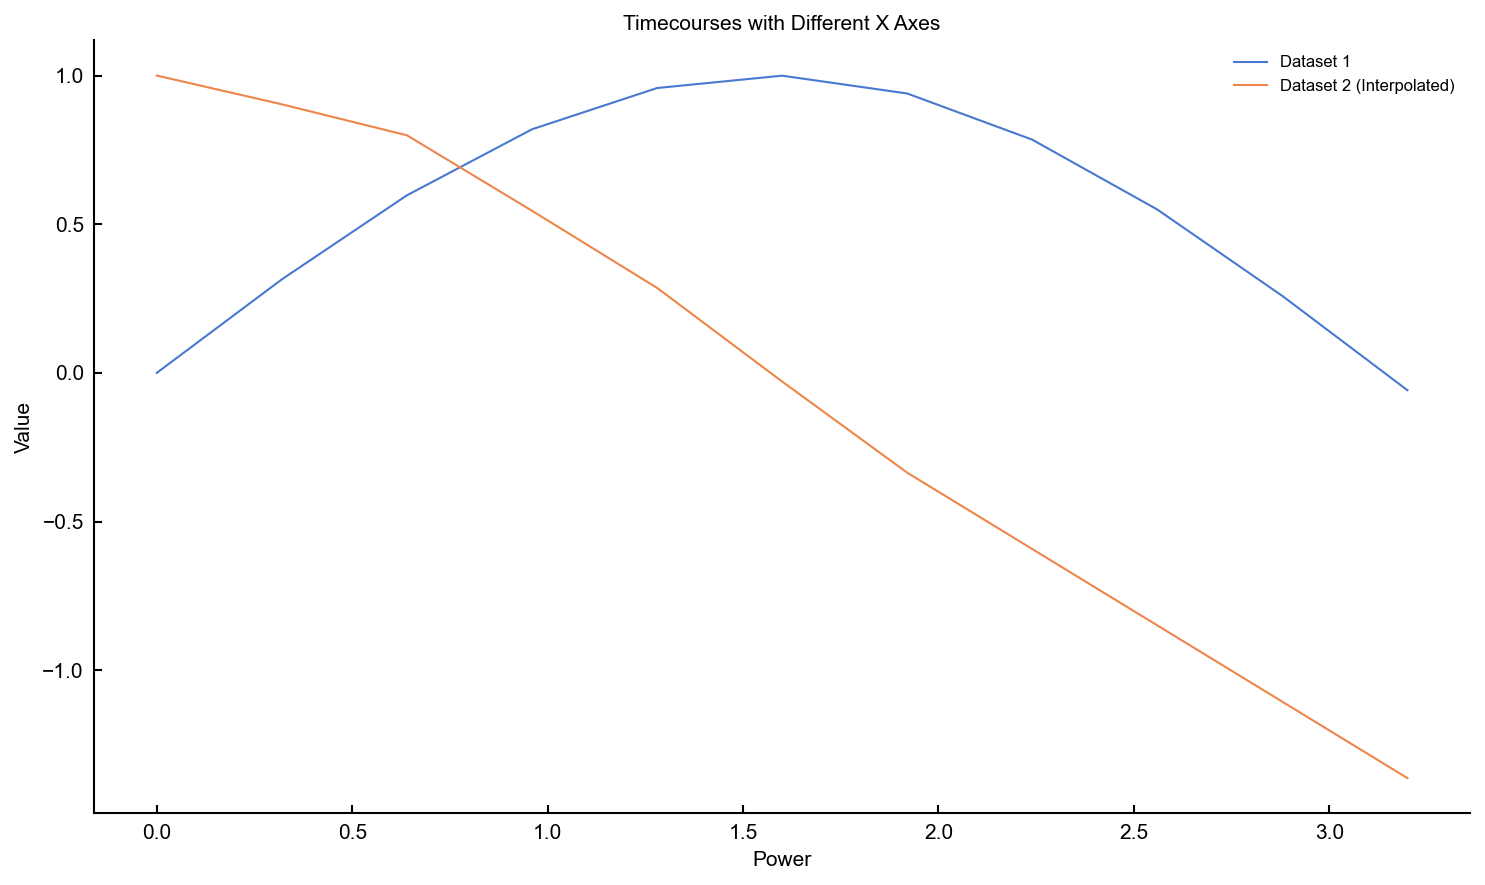

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example data
x1 = np.linspace(0, 3.2, 11)  # 11 powers between 0 and 3.2
y1 = np.sin(x1)  # Replace with your actual data

x2 = np.linspace(0, 2.5, 5)  # 5 powers between 0 and 2.5
y2 = np.cos(x2)  # Replace with your actual data

# Interpolate y2 to match x1
interp_func = interp1d(x2, y2, kind='linear', fill_value='extrapolate')
y2_interp = interp_func(x1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, label='Dataset 1')
plt.plot(x1, y2_interp, label='Dataset 2 (Interpolated)')
plt.xlabel('Power')
plt.ylabel('Value')
plt.title('Timecourses with Different X Axes')
plt.legend()
plt.show()

### figure 3: quant

- there is temporal flexibility
- there is spatial spread
- spread and activation depends on power 
- it is consistent over months 


In [3]:
dataSt725=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-25\1'))

In [4]:
dataSt816=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-16\1'))

In [3]:
dataSt822=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-22\1'))

In [6]:
def stimLensOverlay(ax,data,title='',power=1.7,start=-.3,end=4,n_samples=650,y=400,x=150,width=15,ylim=[-0.08,0.08],cols=2,anchor=(1,1)):
    '''
    plots activity traces in response to different lengths of stimulus
        data - dataset
        x = X location of center of ROI
        y = Y location of center of ROI
        start = where in the trial to start collecting brain activity
        end = where in the trial to end collecting brain activity
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    pxLens=[]
    lens = np.unique(data.pulseLengths).ravel()
    colors=plt.cm.Greens(np.linspace(0,1,lens.shape[0]))
    pws=np.argwhere(data.laserPowers==power).ravel()
    timestamps=np.linspace(start,end,n_samples)

    for iL, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxLens.append(avgOverRoi)
    
    lines = [plt.plot(timestamps, y, label=f'{lens[i]}s',color=colors[i])[0] for i, y in enumerate(pxLens)]

    for iP, power in enumerate(pxLens):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxLens,axis=0),\
                power+scipy.stats.sem(pxLens,axis=0), color=colors[iP],label='_nolegend_',alpha=.08,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.title(f'Length of Stimulus Effect on Inactivation',fontsize=13)
    plt.xlabel('Time (s)',fontsize=7)
    plt.ylabel('Brain Activity (df/f)',fontsize=7)
    plt.ylim(ylim)
    f.tight_layout()

In [4]:
def stimLensOverlayAvg(ax,dataList,power=1.7,start=-.3,end=4,\
                       n_samples=650,ys=[400,400,400],xs=[150,150,150],width=15,title='Length of stimulus effect on inactivation',\
                       ylim=[-0.08,0.08],cols=2,anchor=(1,1)):
    '''
    plots activity traces in response to different lengths of stimulus
        dataList - list of datasets
        x = X location of center of ROI
        y = Y location of center of ROI
        start = where in the trial to start collecting brain activity
        end = where in the trial to end collecting brain activity
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    lens = np.unique(dataList[0].pulseLengths).ravel()
    colors=plt.cm.Greens(np.linspace(0,1,lens.shape[0]))
    timestamps=np.linspace(start,end,n_samples)
    pxData=[]
    for iD, data in enumerate(dataList):
        pxLens=[]
        pws=np.argwhere(data.laserPowers==power).ravel()
        x=xs[iD]
        y=ys[iD]
        for iL, len in enumerate(lens):
            lenTrs = np.argwhere(data.pulseLengths == len).ravel()
            theseTrs=np.intersect1d(lenTrs,pws)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
            pxLens.append(avgOverRoi)
        pxData.append(pxLens)
    pxDataMean = np.mean(pxData,axis=0)
        
    lines = [plt.plot(timestamps, y, label=f'{lens[i]}s',color=colors[i])[0] for i, y in enumerate(pxDataMean)]

    for iP, power in enumerate(pxDataMean):
        # plt.plot(timestamps, power,linewidth=2,label=powers[iP],color=colors[iP])
        plt.fill_between(timestamps, \
                power-scipy.stats.sem(pxDataMean,axis=0),\
                power+scipy.stats.sem(pxDataMean,axis=0), color=colors[iP],label='_nolegend_',alpha=.3,linewidth=0)
    legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
                        columnspacing=0.5,handletextpad=0.3)

    # Change the color of the text in the legend to match the line colors
    for text, line in zip(legend.get_texts(), lines):
        text.set_color(line.get_color())
    # Optionally, remove the lines and markers from the legend
    for legend_line in legend.get_lines():
        legend_line.set_linewidth(0)
    for legend_marker in legend.get_patches():
        legend_marker.set_visible(False)

    plt.title(f'{title}',fontsize=10)
    plt.xlabel('Time (s)',fontsize=7)
    plt.ylabel('Brain Activity (df/f)',fontsize=7)
    plt.ylim(ylim)

In [25]:
def inacTime(ax,data,title='',pows=[1.5,1.7],n_samples=650,y=400,x=170,width=15):
    '''
    quantification of how long activity is below 0 for diff stim lens
        data - dataset
        x = X location of center of ROI
        y = Y location of center of ROI
        pows = what powers of the dataset to look at
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    lens = np.unique(data.pulseLengths).ravel()
    numlens = lens.shape[0]
    pxLens = np.zeros((2,numlens),dtype=float)
    for iP,pow in enumerate(pows):
        pws=np.argwhere(data.laserPowers==pow).ravel()
        for iL, len in enumerate(lens):
            lenTrs = np.argwhere(data.pulseLengths == len).ravel()
            theseTrs=np.intersect1d(lenTrs,pws)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            wf = np.mean(data.tToWFManual(trs),axis=0)
            mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
            mov = mov.reshape(560,560,-1)
            meanimg = data.meanImage.reshape(560,560,-1)
            avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
            videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
            mov_mean_dff = videoROI/avg
            peak = np.min(mov_mean_dff)
            halfpeak=peak/2
            tf = [i<halfpeak for i in mov_mean_dff]
            deac = mov_mean_dff[tf]
            pxLens[iP,iL] = deac.shape[0]*(1/1000)

    colors=['blue','orange']

    for i in range(2):
        yerr = scipy.stats.sem(pxLens[i,:])
        plt.plot(lens,pxLens[i,:],'-o',lw=2,color=colors[i])
        plt.errorbar(lens,pxLens[i,:],yerr=yerr,color=colors[i],label='_nolegend_')
        plt.scatter(lens,pxLens[i,:],color=colors[i],label='_nolegend_')
    pwscorrected = [round(i/2.777777778,2) for i in pows]
    plt.legend(pwscorrected)
    plt.xlabel("Length of stimulus (s)",fontsize=7) 
    plt.xscale('log',base=2)
    plt.ylabel("Time inactivated (s)",fontsize=7)
    plt.title(f'{title}',fontsize=13)

In [22]:
def inacTimeAvg(ax,dataList,title='',pows=[1.5,1.7],n_samples=650,ys=[400,400,400],xs=[170,170,170],width=15):
    '''
    quantification of how long activity is below 0 for diff stim lens
        data - dataset
        x = X location of center of ROI
        y = Y location of center of ROI
        pows = what powers of the dataset to look at
        n_samples = how many samples to split time into
        width = width of ROI from x and y in either direction
        anchor - where to anchor the legend
        cols - columns in legend
    '''
    pxData=[]
    for iD, data in enumerate(dataList):
        lens = np.unique(data.pulseLengths).ravel()
        numlens = lens.shape[0]
        pxLens = np.zeros((2,numlens),dtype=float)
        for iP,pow in enumerate(pows):
            pws=np.argwhere(data.laserPowers==pow).ravel()
            x=xs[iD]
            y=ys[iD]
            for iL, len in enumerate(lens):
                lenTrs = np.argwhere(data.pulseLengths == len).ravel()
                theseTrs=np.intersect1d(lenTrs,pws)
                onTimes = data.laserOn[theseTrs]
                trs = [np.linspace(-.3+on, 4+on, n_samples) for on in onTimes]
                trs = np.squeeze(np.array(trs))
                
                wf = np.mean(data.tToWFManual(trs),axis=0)
                mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
                mov = mov.reshape(560,560,-1)
                meanimg = data.meanImage.reshape(560,560,-1)
                avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
                videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
                mov_mean_dff = videoROI/avg
                peak = np.min(mov_mean_dff)
                halfpeak=peak/2
                tf = [i<halfpeak for i in mov_mean_dff]
                deac = mov_mean_dff[tf]
                pxLens[iP,iL] = deac.shape[0]*(1/1000)
        pxData.append(pxLens)
    pxDataMean = np.mean(pxData,axis=0)

    colors=plt.cm.Greens(np.linspace(0,1,numlens))
    for i in range(1):
        yerr = scipy.stats.sem(pxDataMean[i,:])
        plt.plot(lens,pxDataMean[i,:],'-o',lw=2,color='forestgreen')
        plt.errorbar(lens,pxDataMean[i,:],yerr=yerr,color='forestgreen',label='_nolegend_')
        #this part is for one line making all pts diff colors
        for j in range(pxDataMean.shape[1]):
            pt = pxDataMean[i,j]
            plt.scatter(lens[j],pt,color=colors[j],label='_nolegend_')
    
    pwscorrected = [round(i/2.777777778,2) for i in pows]
    plt.legend(pwscorrected)
    plt.xlabel("Length of stimulus (s)",fontsize=7)
    plt.xscale('log',base=2)
    plt.ylabel("Time inactivated (s)",fontsize=7)
    plt.title(f'{title}',fontsize=13)

In [ ]:
def powerQuantReturn(data,galvoX=0,galvoY=0,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        pxPowers.append(avgOverRoi)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=1, fill_value='extrapolate')

    timeX = pixelInterp(time)

    return(timeX)

In [ ]:
def inacOverSessions(ax,dataList,galvoXList,galvoYList,weeksFrom,power=1.5,\
                     time=90,n_samples=650,ys=[380,380,380],xs=[170,170,170],width=15,\
                     title='',ylim=[-.05,0]):
    '''
    plots the inactivaton of certain powers over increasing time from initial injection
        weeksFrom - list that aligns with dataList. single integer 
                    that says how many weeks from injection the data was collected
        dataList
        galvoXList
    '''
    pxData=[]
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    for iD,data in enumerate(dataList):
        x=xs[iD]
        y=ys[iD]
        galvoXTrs=np.argwhere(data.galvoX==galvoXList[iD]).ravel()
        galvoYTrs=np.argwhere(data.galvoY==galvoYList[iD]).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)

        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        wf = np.mean(data.tToWFManual(trs),axis=0)
        mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
        mov = mov.reshape(560,560,-1)
        meanimg = data.meanImage.reshape(560,560,-1)
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        mov_mean_dff = videoROI/avg
        avgOverRoi=np.mean(mov_mean_dff,axis=(0,1))
        
        pixelInterp = scipy.interpolate.interp1d(timestamps, avgOverRoi, axis=0, fill_value='extrapolate')
        timeX = pixelInterp(time)
        pxData.append(timeX)
    # pxDataMean = np.mean(pxData,axis=0)
    yerr = scipy.stats.sem(pxData,axis=0)

    plt.plot(weeksFrom,pxData,'-o',c='k',lw=2)
    plt.errorbar(weeksFrom,pxData,yerr=yerr,c='k')
    plt.scatter(weeksFrom,pxData)
    plt.xlabel("Weeks from injection",fontsize=10)
    plt.ylabel('Brain activity at peak (df/f)')
    plt.title(f'{title}',fontsize=13)
    plt.ylim(ylim)
    


#### panels

##### temp and spat

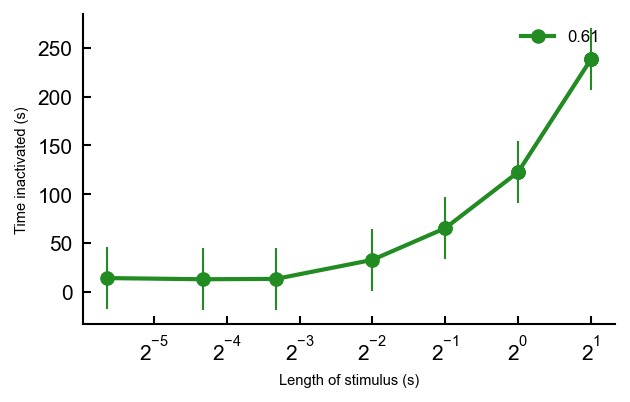

In [23]:
# dataList=[dataSt725,dataSt816,dataSt822]
dataList = [dataSt822]
f = plt.figure(figsize=(8,5))
gs=mpl.gridspec.GridSpec(2,2)

x=[170]
ax = plt.subplot(gs[0])
# stimLensOverlayAvg(ax,dataList=dataList,xs=x,anchor=(1,0))

# ax=plt.subplot(gs[1])
inacTimeAvg(ax,dataList=dataList,xs=x,pows=[1.7])

# ax = plt.subplot(gs[2])
# spatialResX(ax) #spatial resolution 

# ax = plt.subplot(gs[3])
# xQuant(ax) #quantify spatial resolution
f.tight_layout()

In [11]:
x=np.linspace(-.3,1,650)

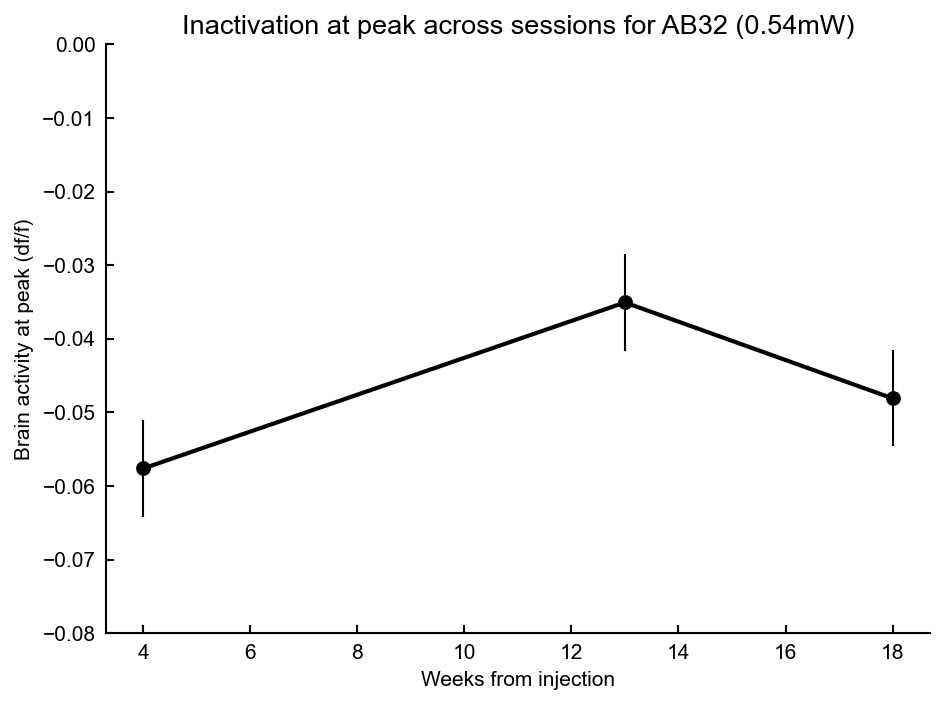

In [9]:
data=[dataOp425_AB32,dataOp621_AB32,dataOp729_AB32]
galvoX=[0,0,0]
galvoY=[3.3,4,4]
weeksFrom=[4,13,18]
fig,ax = plt.subplots()
inacOverSessions(ax,dataList=data,galvoXList=galvoX,galvoYList=galvoY,weeksFrom=weeksFrom,\
                 title='Inactivation at peak across sessions for AB32 (0.54mW)', power=1.5,\
                 ylim=[-.08,0])

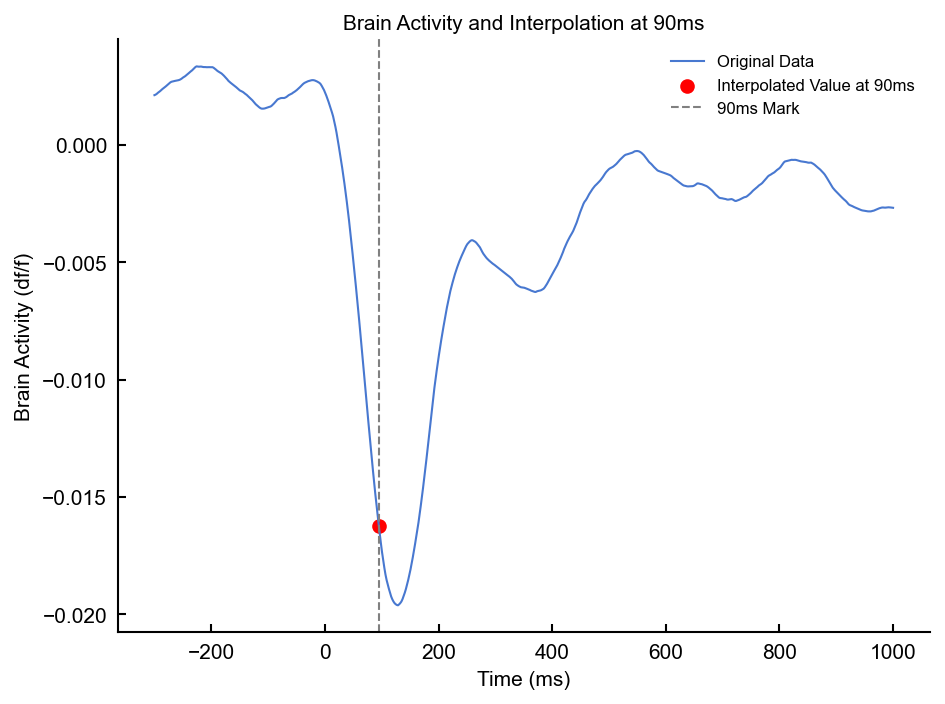

In [33]:
# Plot to visualize the interpolation around 90ms
plt.plot(timestamps, avgOverRoi, label='Original Data')
plt.scatter([time], [pixelInterp(time)], color='red', label='Interpolated Value at 90ms')
plt.axvline(x=95, color='gray', linestyle='--', label='90ms Mark')
plt.xlabel('Time (ms)')
plt.ylabel('Brain Activity (df/f)')
plt.legend()
plt.title('Brain Activity and Interpolation at 90ms')
plt.show()


##### over days

import

In [60]:
dataOp622_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))
dataOp709_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))
dataOp712_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-12\1'))
dataOp718_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-18\1'))
dataOp809_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-09\1'))
dataOp818_AL33=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-08-18\1'))


KeyboardInterrupt: 

In [61]:
quant622=powerQuantReturn(data=dataOp622_AL33,y=380,x=170,galvoX=0,galvoY=3)
quant709=powerQuantReturn(data=dataOp709_AL33,y=380,x=170,galvoX=0,galvoY=2)
quant712=powerQuantReturn(data=dataOp712_AL33,y=380,x=170,galvoX=0,galvoY=2)
quant718=powerQuantReturn(data=dataOp718_AL33,y=380,x=170,galvoX=0,galvoY=2)
quant809=powerQuantReturn(data=dataOp809_AL33,y=380,x=170,galvoX=0,galvoY=3)
quant818=powerQuantReturn(data=dataOp818_AL33,y=380,x=170,galvoX=0,galvoY=3)
days=[quant622,quant709,quant712,quant718,quant809,quant818]

MemoryError: Unable to allocate 718. MiB for an array with shape (313600, 300) and data type float64

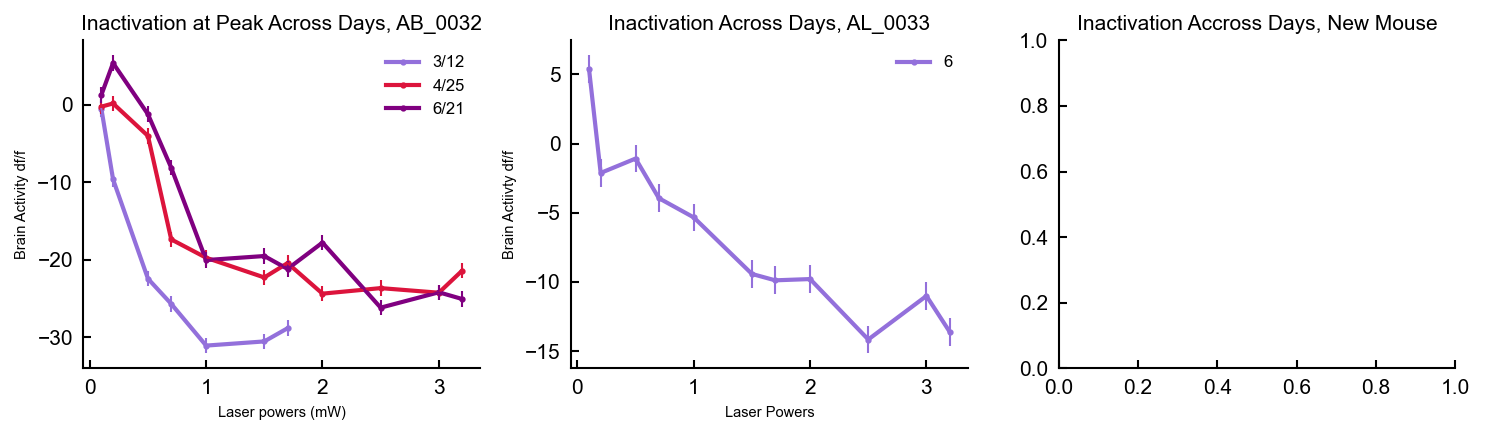

In [ ]:
mouse='AL33'
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp709_AL33.laserPowers)
powers = [round(i/2.777777778,2) for i in powers]

colors=plt.cm.Blues(np.linspace(0.5,1,4))
labels=['6/22','7/08', '7/12','7/18','8/09','8/18']

lines = [plt.plot(powers, y, label=f'{labels[i]}',color=colors[i])[0] for i, y in enumerate(days)]

for i,day in enumerate(days):
    plt.plot(powers[0:len(day)],day,'-o',c=colors[i],lw=1,markersize=2)

    plt.scatter(powers[0:len(day)],day,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)
legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
                        columnspacing=0.5,handletextpad=0.3)

# Change the color of the text in the legend to match the line colors
for text, line in zip(legend.get_texts(), lines):
    text.set_color(line.get_color())
# Optionally, remove the lines and markers from the legend
for legend_line in legend.get_lines():
    legend_line.set_linewidth(0)
for legend_marker in legend.get_patches():
    legend_marker.set_visible(False)


plt.legend(labels,loc='upper right',fontsize=5)
plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel('Brain Activity df/f',fontsize=7)
plt.title(f"Inactivation at Peak Across Days {mouse}",fontsize=8)

##### over preps

In [9]:
quantAB32=powerQuantReturn(data=dataOp425_AB32,galvoX=0,galvoY=3.3)
quantAL33=powerQuantReturn(data=dataOp622_AL33,galvoX=0,galvoY=3)
quantAL34=powerQuantReturn(data=dataOp820_AL34,galvoX=0,galvoY=3)
mice=[quantAL33,quantAL34,quantAB32]

Text(0.5, 1.0, 'Inactivation at Peak Across Preps')

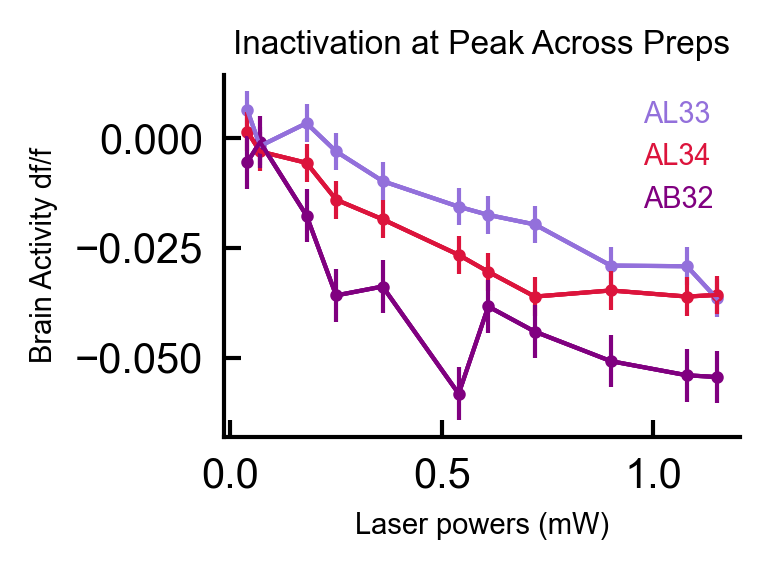

In [10]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp425_AB32.laserPowers)
powers = [round(i/2.777777778,2) for i in powers]
colors=['mediumpurple', 'crimson', 'purple','mediumvioletred','hotpink']
labels=['AL33','AL34','AB32']

lines = [plt.plot(powers, y, label=f'{labels[i]}',color=colors[i])[0] for i, y in enumerate(mice)]

for i,mouse in enumerate(mice):
    plt.plot(powers[0:len(mouse)],mouse,'-o',c=colors[i],lw=1,markersize=2)

    plt.errorbar(powers[0:len(mouse)],mouse,yerr=scipy.stats.sem(mouse),c=colors[i])

    plt.scatter(powers[0:len(mouse)],mouse,label='_nolegend_',c=colors[i],s=.5)
    
cols=1
anchor=(1,1)
legend = plt.legend(ncols=cols,loc='upper right',bbox_to_anchor=anchor,fontsize='x-small',\
                        columnspacing=0.5,handletextpad=0.3)

# Change the color of the text in the legend to match the line colors
for text, line in zip(legend.get_texts(), lines):
    text.set_color(line.get_color())
# Optionally, remove the lines and markers from the legend
for legend_line in legend.get_lines():
    legend_line.set_linewidth(0)
for legend_marker in legend.get_patches():
    legend_marker.set_visible(False)

plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel("Brain Activity df/f",fontsize=7)
plt.title("Inactivation at Peak Across Preps",fontsize=8)

#### Spatial Options

In [49]:
def spatialResY(ax):
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)
            
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        # videoAvg = np.mean(videoAvg, axis=2)
        videoAvg = videoAvg[:,:,0]
        videoROI = videoAvg[:, 200] # activity across one line
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        data = spreadByPower[count]
        data = gaussian_filter1d(data, sigma=3)
        plt.plot(data,np.linspace(0,560,560),c='k')  
    plt.title("Spatial spread over vertical line")
    plt.xlabel("activity")
    plt.ylabel("location 560:560")


In [50]:
def yQuant(ax):
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)
            
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        # videoAvg = np.mean(videoAvg, axis=2)
        videoAvg = videoAvg[:,:,0]
        videoROI = videoAvg[:, 200] # activity across one line
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)
    half_widths=[]
    for power in spreadByPower:
        peaks,properties=scipy.signal.find_peaks(power,height=[None,None],width=[None,None],distance=100)
        widths = scipy.signal.peak_widths(power,peaks)
        half_widths.append(widths[0][0])
    plt.plot(half_widths,color='k',linewidth=1.5)
    plt.title('Half Widths - Space',fontsize=10)
    plt.xlabel('Powers',fontsize=7)
    plt.ylabel('Peak Width',fontsize=7)

In [51]:
def squareRes(ax,x1,x2,y1,y2):
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.07, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)

        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)

        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        videoAvg = np.mean(videoAvg, axis=2)
    plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
    rect = Rectangle((x1,y1),width=(x2-x1),height=(y2-y1),edgecolor='orange',facecolor='none',lw=4)
    ax.add_patch(rect)
    rect.set_edgecolor('orange')

In [ ]:
def spatialResX(ax):
    '''
    spatial resolution
    how to do this? along lines or do an ROI?
    '''
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power)) # find trials
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

        activity = dataOp.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
        
        activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
        dwf = np.array(dwf)
        avg = np.mean(dwf, axis=1)
        
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
        # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
        videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
        videoROI = videoAvg[250, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)

    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        data = spreadByPower[count]
        data = gaussian_filter1d(data, sigma=2)
        plt.plot(data,c='k') 
    # plt.title("Spatial spread over horizontal line")
    plt.xlabel("location 560:560")
    plt.ylabel("activity")

    plt.title('spatial resolution')


In [ ]:
def xQuant(ax):
    '''
    quantifying spatial resolution. also half-width?
    '''
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power)) # find trials
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

        activity = dataOp.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
        
        activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
        dwf = np.array(dwf)
        avg = np.mean(dwf, axis=1)
        
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
        # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
        videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
        videoROI = videoAvg[230:270, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
        videoROI = np.mean(videoAvg,axis=(0))
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)

    half_widths=[]
    for power in spreadByPower:
        peaks,properties=scipy.signal.find_peaks(power,height=[None,None],width=[None,None],distance=100)
        widths = scipy.signal.peak_widths(power,peaks)
        half_widths.append(widths[0][0])
    plt.plot(half_widths,color='k',linewidth=1.5)
    plt.title('Half Widths - Space',fontsize=10)
    plt.xlabel('Powers',fontsize=7)
    plt.ylabel('Peak Width',fontsize=7)


In [52]:
def squareQuant(ax,x1,x2,y1,y2):
    spreadByPower=[]
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.07, i+0.2, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)

        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)

        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        videoROI = videoAvg[y1:y2, x1:x2] # ROI vid with average activity

        videoROI = videoROI.flatten()
        activities = [x for x in videoROI if x <= -75]
        
        spreadByPower.append(len(activities)/((x2-x1)*(y2-y1)))
    powers = np.unique(dataOp.laserPowers)
    plt.plot(powers,spreadByPower,color='darkslateblue')
    # plt.fill_between(spreadByPower[0], \
    #                  np.mean(spreadByPower, axis=0)-scipy.stats.sem(spreadByPower,axis=0),\
    #                  np.mean(spreadByPower,axis=0)+scipy.stats.sem(spreadByPower,axis=0), color='lavender')
    plt.xlabel("power")
    plt.ylabel("percentage spread")
    plt.title(f'Percentage spatial spread')

##### adapting spatial

Text(0.5, 1.0, 'Percentage spatial spread within a 400x140 ROI')

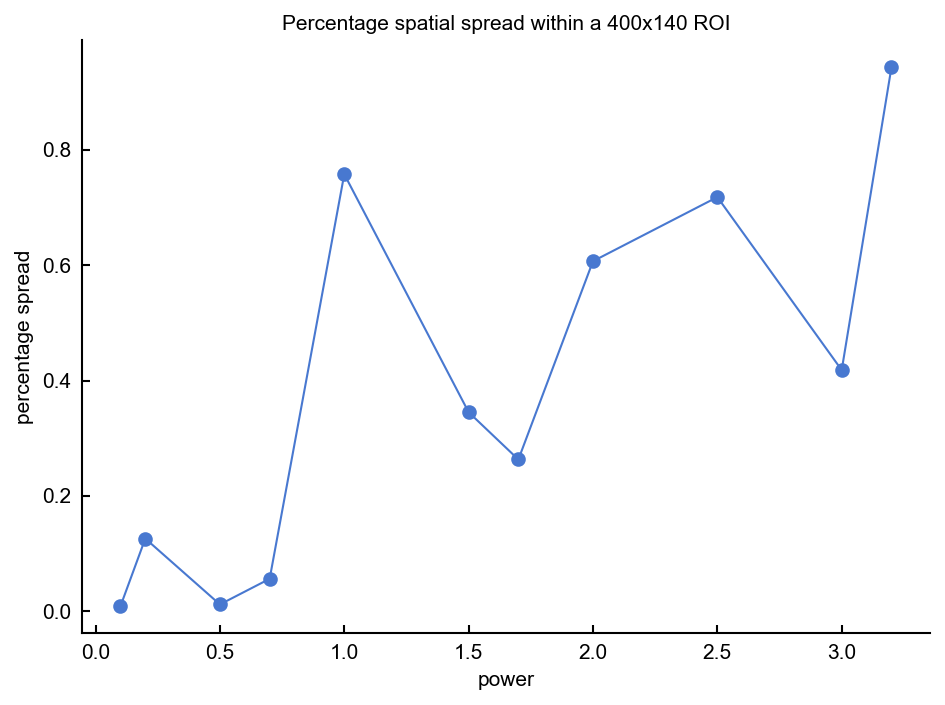

In [95]:
data=dataOp622_AL33
y=380
x=270
xwidth=200
ywidth=70
spreadByPower=[]
movs=[]
vids=[]
galvoX=0
galvoY=3
n_samples=100
galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
loc=np.intersect1d(galvoXTrs,galvoYTrs)
for count,power in enumerate(np.unique(data.laserPowers)):
    pwTrs = np.argwhere(data.laserPowers == power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(on+0.03, .25+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    wf = np.mean(data.tToWFManual(trs),axis=0)
    mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
    mov = mov.reshape(560,560,-1)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-ywidth):(y+ywidth),(x-xwidth):(x+xwidth)]
    videoROI = mov[(y-ywidth):(y+ywidth),(x-xwidth):(x+xwidth)] # ROI vid with average activity
    movCorr = mov/meanimg
    vids.append(movCorr)
    movs.append(np.mean(movCorr,axis=(0,1)))

    movCorrflat = movCorr.flatten()
    movCorrflat = np.array(movCorrflat)
    activities = [x for x in movCorrflat if x <= -0.001]
    
    spreadByPower.append(len(activities)/(movCorrflat.shape[0]))
powers = np.unique(data.laserPowers)
plt.scatter(powers,spreadByPower)
plt.plot(powers,spreadByPower)
plt.xlabel("power")
plt.ylabel("percentage spread")
plt.title(f'Percentage spatial spread within a {xwidth*2}x{ywidth*2} ROI')

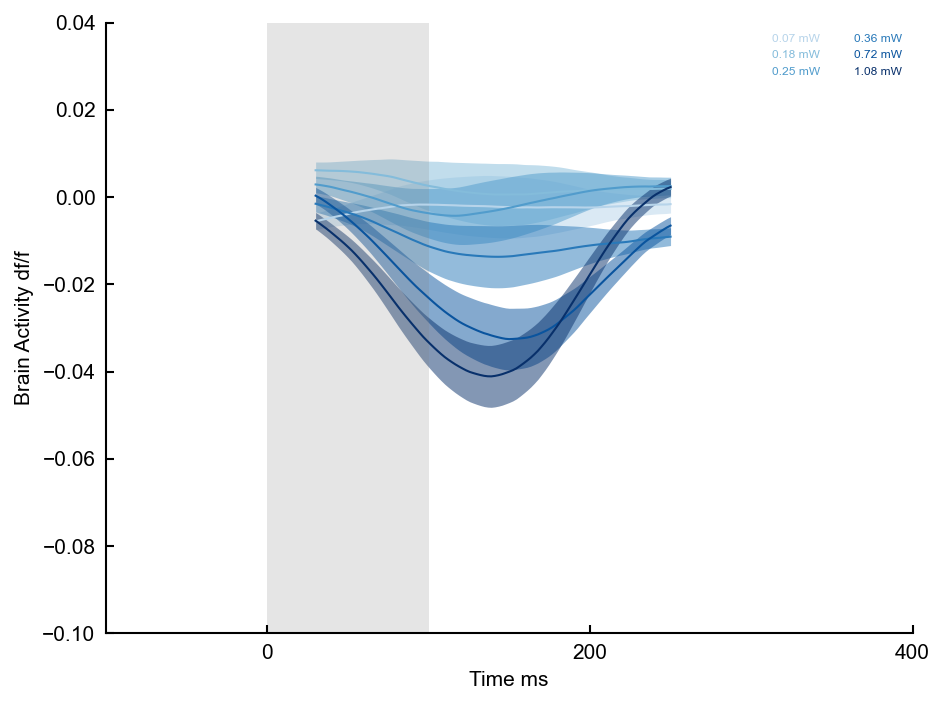

In [94]:
fig,ax=plt.subplots()

wfTrace(ax,data=dataOp622_AL33,galvoX=0,galvoY=3,y=380,x=150,\
        n_samples=100,start=0.03,end=.25,xlim=[-100,400],\
            powers=[0.2,0.5,0.7,1,2,3],lenpows=6)

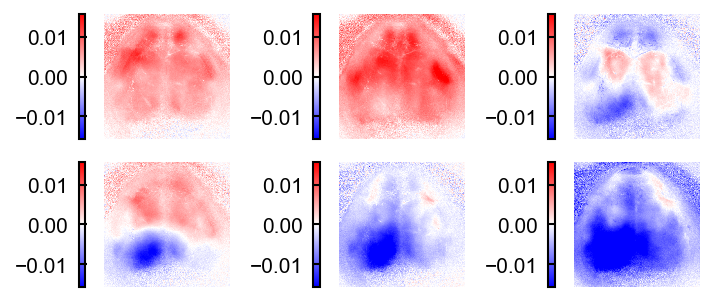

In [86]:
vids = np.array(vids)
cols=3
rows=10
skip=50
f = plt.figure(figsize=(5,10))
gs=mpl.gridspec.GridSpec(rows,cols)

vmin, vmax = np.percentile(vids[5,:, :, :], [2, 98])
norm = Normalize(vmin=-max(abs(vmin), vmax), vmax=max(abs(vmin), vmax))

for i in range(6):
    ax = plt.subplot(gs[i])
    plt.imshow(vids[i*2,:,:,20],cmap='bwr',norm=norm)
    plt.colorbar(location='left')
    plt.axis('off')

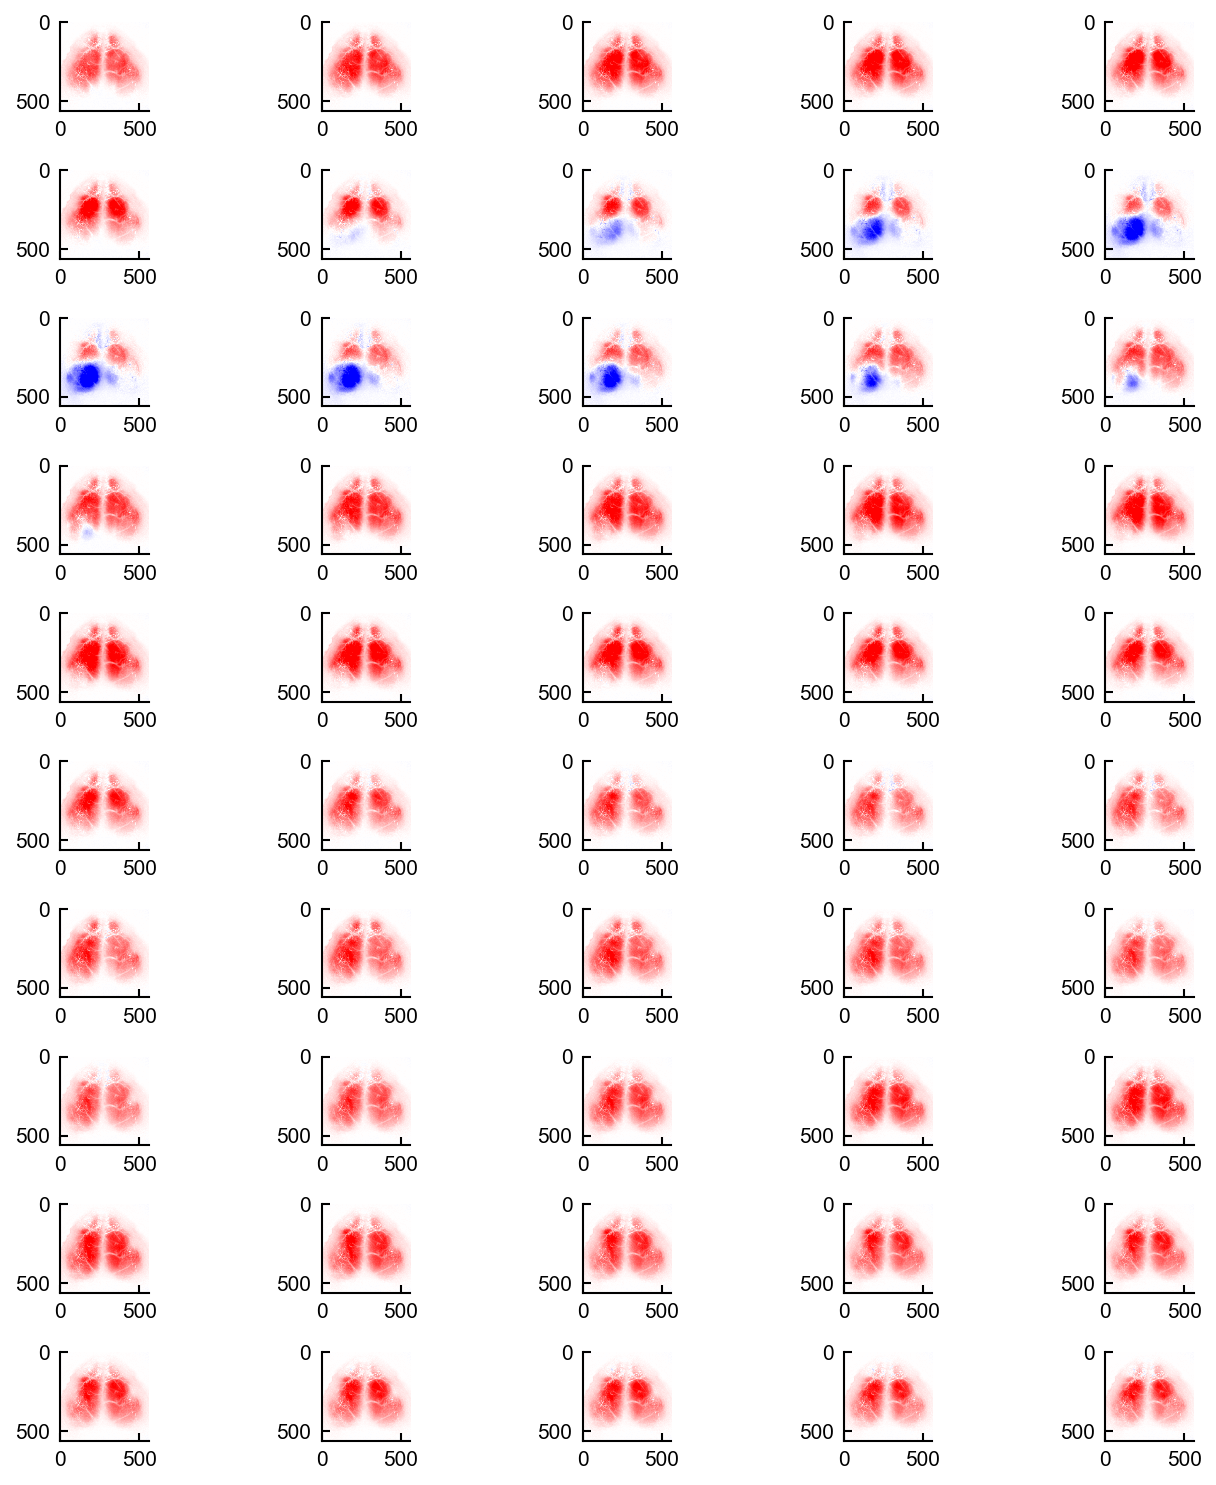

In [41]:
f = plt.figure(figsize=(10,10))
for i in range(50):
    ax = plt.subplot(gs[i])
    plt.imshow(vids[5,:,:,i*2],cmap='bwr',norm=norm)

### figure 4: contralateral

- activity in the left doesnt predict the right and vice versa

In [69]:
def contralatTraces(ax,data,galvoX=0,galvoY=0,power=2,n_samples=650,legend=False):
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(data.laserPowers==power).ravel() 
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim

    #all the pixels we might need
    pixel_RightPost=np.ravel_multi_index((390,400),(data.py, data.px))
    pixel_LeftPost = np.ravel_multi_index((400,200),(data.py,data.px))
    pixel_LeftAnt=np.ravel_multi_index((120,190),(data.py, data.px))
    pixel_RightAnt=np.ravel_multi_index((120,310),(data.py, data.px))

    #find trials
    px = np.intersect1d(galvoYTrs,galvoXTrs)
    theseTrs=np.intersect1d(px,power)
    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLP=[]
    thisPowerRP=[]
    thisPowerLA=[]
    thisPowerRA=[]
    #finding movies for those trials in those locations
    for iT, tr in enumerate(trs):
        wf=data.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)

        #find traces for each pixel

        #posterior
        movRightP=data.svdSpat[pixel_RightPost]@dwf
        thisPowerRP.append(movRightP)
        movLeftP=data.svdSpat[pixel_LeftPost]@dwf
        thisPowerLP.append(movLeftP)

        #anterior
        movRightA=data.svdSpat[pixel_RightAnt]@dwf
        thisPowerRA.append(movRightA)
        movLeftA=data.svdSpat[pixel_LeftAnt]@dwf
        thisPowerLA.append(movLeftA)

    thisPowerLP=np.array(thisPowerLP)
    thisPowerRP=np.array(thisPowerRP)
    thisPowerLA=np.array(thisPowerLA)
    thisPowerRA=np.array(thisPowerRA)

    plt.plot(timestamps,np.mean(thisPowerLP,axis=0),color='darkviolet',label='Left Post')
    plt.plot(timestamps,np.mean(thisPowerRP,axis=0),color='violet',label='Right Post')
    plt.plot(timestamps,np.mean(thisPowerLA,axis=0),color='blue',label='Left Ant')
    plt.plot(timestamps,np.mean(thisPowerRA,axis=0),color='deepskyblue',label='Right Ant')
    if legend:
        plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    pw=power/2.77778
    plt.title(f'Stimulating Posterior Right 0.72 mW')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    plt.ylim([-50,50])

In [327]:
def stimRight(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==0).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((200,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Upper Right 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [328]:
def stimLowerLeft(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==0).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Left Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [329]:
def stimLowerRight(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Right Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [32]:
def contralatPlot(data,galvoX=0,galvoY=3,start=-.3,end=1,n_samples=650,powerpick=3,width=15, info='Posterior Left'):
    '''
    plots activity traces across 4 locations of cortex for one stimulation location
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        start - where in trial to start collecting activity
        end - where in trial to end collecting activity
        powerpick - what power to collect this data for
        info - part of the title, typically stimulus location
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    #pixel needs Y, X (hardcoded right now for ease)
    pixels = [[180,200], #left ant
              [150,350], # right ant
              [400,180], #left post
              [400,330]] #right postt
    colors=['darkviolet','violet','blue','deepskyblue']
    labels = ['Left Ant', 'Right Ant', 'Left Post', 'Right Post']

    #presets
    timestamps=np.linspace(start,end,n_samples)*1000
    meanimg = data.meanImage.reshape(560,560,-1)
    power = np.argwhere(data.laserPowers==powerpick).ravel() 
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim
    
    #find trials
    px = np.intersect1d(galvoYTr,galvoXTr)
    theseTrs=np.intersect1d(px,power)
    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(start+on,end+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))
    wf = np.mean(data.tToWFManual(trs),axis=0)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    mov = mov.reshape(560,560,-1)

    for i,pixel in enumerate(pixels):
        y=pixel[0]
        x=pixel[1]
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        avgoveroi = videoROI/avg
        trace=np.mean(avgoveroi,axis=(0,1))
        plt.plot(timestamps,trace,linewidth=2,color=colors[i],label=labels[i])
        plt.fill_between(timestamps, \
                trace-scipy.stats.sem(trace,axis=0),\
                trace+scipy.stats.sem(trace,axis=0), color=colors[i], label='_nolegend_',alpha=.3,linewidth=0)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    powercorr = round(powerpick/2.7778,2)
    plt.title(f'Stimulating {info} {powercorr} mW',fontsize=10)
    plt.xlabel('Time (ms)',fontsize=7)
    plt.ylabel('$\Delta F$/F',fontsize=7)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')

In [51]:
def contraQuant(ax, data, galvoX=0, galvoY=0,start=-.3, end=1, powerpick=3, n_samples=650, width=15, info='Left Anterior'):
    times=[90,180,300,430,600]
    pixels = [[180,200], #left ant
                [150,350], # right ant
                [400,180], #left post
                [400,330]] #right postt
    labels=['Left Ant','Right Ant', 'Left Post', 'Right Post']
    colors=['darkviolet','violet','blue','deepskyblue']
    #presets
    timestamps=np.linspace(start,end,n_samples)*1000
    meanimg = data.meanImage.reshape(560,560,-1)
    power = np.argwhere(data.laserPowers==powerpick).ravel() 
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim

    #find trials
    px = np.intersect1d(galvoYTr,galvoXTr)
    theseTrs=np.intersect1d(px,power)
    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(start+on,end+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))
    wf = np.mean(data.tToWFManual(trs),axis=0)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T] 
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    mov = mov.reshape(560,560,-1)

    for i,pixel in enumerate(pixels):
        peaks=[]
        y=pixel[0]
        x=pixel[1]
        avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
        videoROI = mov[(y-width):(y+width),(x-width):(x+width)] # ROI vid with average activity
        avgoveroi = videoROI/avg
        trace=np.mean(avgoveroi,axis=(0,1))

        pixelInterp = scipy.interpolate.interp1d(timestamps, trace, axis=0, fill_value='extrapolate')

        for j in times:
            peaks.append(pixelInterp(j))
        # plt.plot(times,peaks,'-o',c=colors[i],lw=2,label=labels[i])
        # plt.errorbar(times,peaks,yerr=.01,c=colors[i],label='_nolabel_')
        plt.scatter(times,peaks,c=colors[i],label=labels[i])
    plt.title(f'Stimulating {info}, Peaks Across Areas', fontsize=13)
    plt.xlabel('Time (ms)', fontsize=10)
    plt.ylabel('Brain Activity (df/f)')
    plt.legend(bbox_to_anchor=(1.1,1))


#### panels

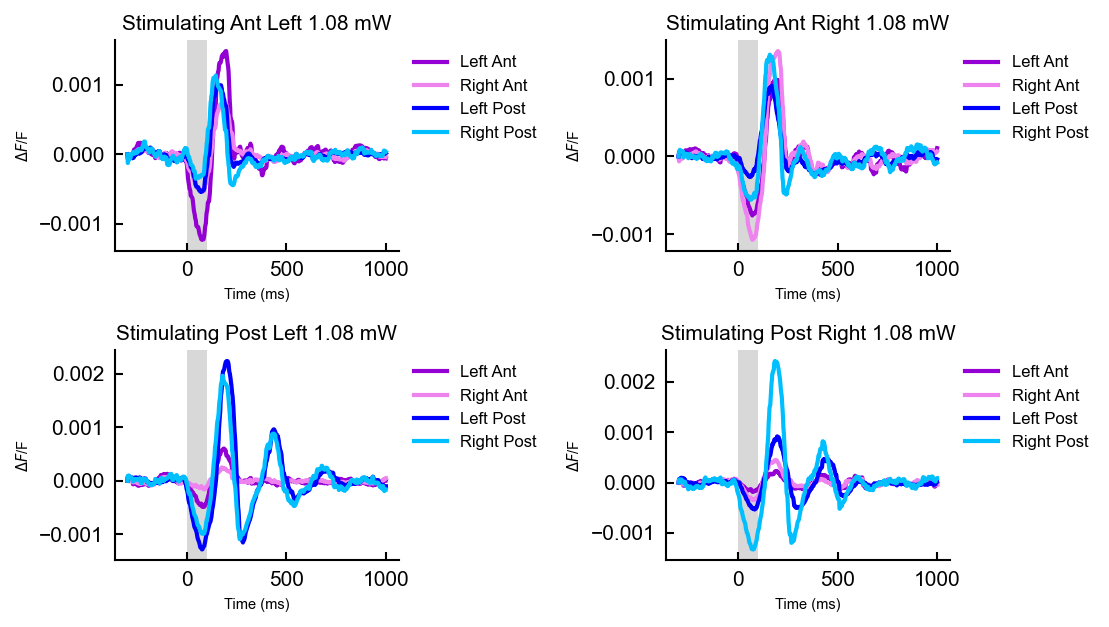

In [33]:
f = plt.figure(figsize=(7.5,6))
gs=mpl.gridspec.GridSpec(3,2)

ax = plt.subplot(gs[0]) #top left
contralatPlot(data=dataOp820_AL34,galvoX=0,galvoY=0,info='Ant Left')

ax = plt.subplot(gs[1]) #top right
contralatPlot(data=dataOp820_AL34,galvoX=2,galvoY=0,info='Ant Right')

ax = plt.subplot(gs[2]) #bottom left
contralatPlot(data=dataOp820_AL34,galvoX=0,galvoY=3,info='Post Left')

ax = plt.subplot(gs[3]) #bottom right
contralatPlot(data=dataOp820_AL34,galvoX=2,galvoY=3,info='Post Right')

f.tight_layout()


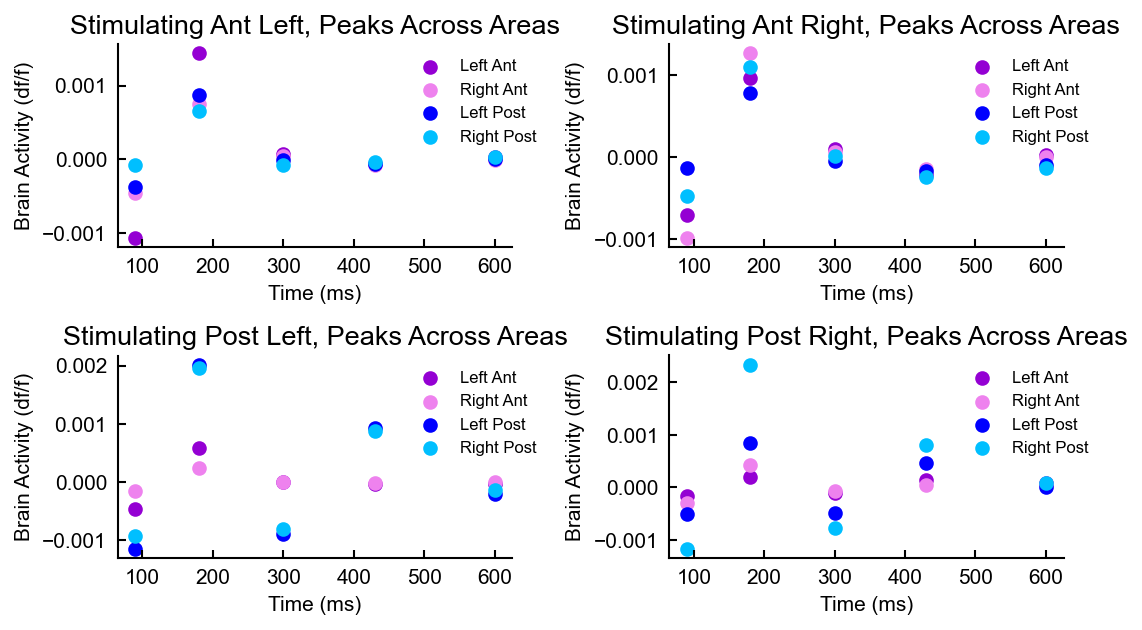

In [52]:
f = plt.figure(figsize=(7.5,6))
gs=mpl.gridspec.GridSpec(3,2)

ax = plt.subplot(gs[0]) #top left
contraQuant(ax,data=dataOp820_AL34,galvoX=0,galvoY=0,info='Ant Left')

ax = plt.subplot(gs[1]) #top right
contraQuant(ax,data=dataOp820_AL34,galvoX=2,galvoY=0,info='Ant Right')

ax = plt.subplot(gs[2]) #bottom left
contraQuant(ax,data=dataOp820_AL34,galvoX=0,galvoY=3,info='Post Left')

ax = plt.subplot(gs[3]) #bottom right
contraQuant(ax,data=dataOp820_AL34,galvoX=2,galvoY=3,info='Post Right')

f.tight_layout()
